## Satellite imagery usage
I'm just investigating how to pull images from the Sentinel 2 satellite, querying a specific place and time. I used the API's provided example: https://sentinelhub-py.readthedocs.io/en/latest/examples/data_search.html#Sentinel-Hub-Catalog-API

In [1]:
# Project dependencies
# ! pip install sentinelsat
! pip install sentinelhub --upgrade

In [2]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'ec1e85c6-0718-4b23-8bfb-6ecd88cc5599'
config.sh_client_secret = 'Gha8Bk_nYHb>yzoo.ShpXO8ll<I0Ctejf/yE2)3J'
config.save()

In [5]:
from sentinelhub import SentinelHubCatalog


catalog = SentinelHubCatalog(config=config)

catalog.get_info()

{'stac_version': '0.9.0',
 'stac_extensions': [],
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v0.9.0 implementation by Sentinel Hub',
 'links': [{'href': 'https://services.sentinel-hub.com/api/v1/catalog/',
   'rel': 'self'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/conformance',
   'rel': 'conformance'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/search',
   'rel': 'search'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections',
   'rel': 'data'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l1c',
   'rel': 'child'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-1-grd',
   'rel': 'child'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l2a',
   'rel': 'child'}]}

In [10]:
%matplotlib inline

import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import SHConfig, BBox, CRS, DataCollection,\
    SentinelHubRequest, filter_times, bbox_to_dimensions, \
    MimeType, SentinelHubDownloadClient


In [11]:
caspian_sea_bbox = BBox([49.9604, 44.7176, 51.0481, 45.2324], crs=CRS.WGS84)
time_interval = '2020-12-10', '2021-02-01'

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=caspian_sea_bbox,
    time=time_interval,
    query={
        "eo:cloud_cover": {
            "lt": 5
        }
    },
    fields={
        "include": [
            "id",
            "properties.datetime",
            "properties.eo:cloud_cover"
        ],
        "exclude": []
    }

)

results = list(search_iterator)
print('Total number of results:', len(results))

results

Total number of results: 11


[{'id': 'S2A_MSIL2A_20210125T073201_N0214_R049_T39TVK_20210125T105105',
  'properties': {'datetime': '2021-01-25T07:37:23Z', 'eo:cloud_cover': 3.84}},
 {'id': 'S2A_MSIL2A_20210125T073201_N0214_R049_T39TWK_20210125T105105',
  'properties': {'datetime': '2021-01-25T07:37:20Z', 'eo:cloud_cover': 0.59}},
 {'id': 'S2A_MSIL2A_20210125T073201_N0214_R049_T39TVL_20210125T105105',
  'properties': {'datetime': '2021-01-25T07:37:09Z', 'eo:cloud_cover': 0.0}},
 {'id': 'S2A_MSIL2A_20210125T073201_N0214_R049_T39TWL_20210125T105105',
  'properties': {'datetime': '2021-01-25T07:37:05Z', 'eo:cloud_cover': 0.05}},
 {'id': 'S2A_MSIL2A_20210105T073311_N0214_R049_T39TVK_20210105T100353',
  'properties': {'datetime': '2021-01-05T07:37:23Z', 'eo:cloud_cover': 0.33}},
 {'id': 'S2A_MSIL2A_20210105T073311_N0214_R049_T39TVL_20210105T100353',
  'properties': {'datetime': '2021-01-05T07:37:09Z', 'eo:cloud_cover': 3.42}},
 {'id': 'S2A_MSIL2A_20201226T073321_N0214_R049_T39TWK_20201226T103718',
  'properties': {'datet

In [12]:
time_difference = dt.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

unique_acquisitions

[datetime.datetime(2020, 12, 11, 7, 37, 6, tzinfo=tzutc()),
 datetime.datetime(2020, 12, 26, 7, 37, 4, tzinfo=tzutc()),
 datetime.datetime(2021, 1, 5, 7, 37, 9, tzinfo=tzutc()),
 datetime.datetime(2021, 1, 25, 7, 37, 5, tzinfo=tzutc())]

In [13]:
false_color_evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B03", "B04", "B08"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B08, sample.B04, sample.B03];
    }
"""


process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=false_color_evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(timestamp - time_difference, timestamp + time_difference)
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=caspian_sea_bbox,
        size=bbox_to_dimensions(caspian_sea_bbox, 100),
        config=config
    )
    process_requests.append(request)

In [14]:
%%time

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

data[0].shape

CPU times: user 207 ms, sys: 69.5 ms, total: 276 ms
Wall time: 22.6 s


(567, 861, 3)

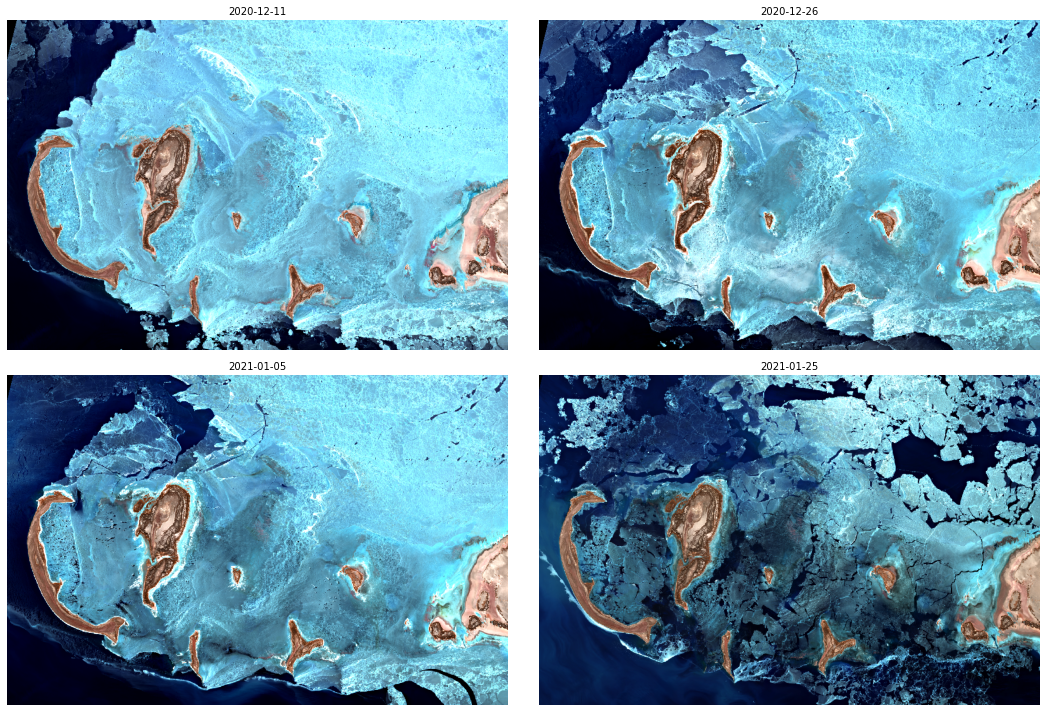

In [15]:
ncols, nrows = 2, 2

fig, axis = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 10),
    subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
)

for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):
    ax = axis[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(timestamp.date().isoformat(), fontsize=10)

plt.tight_layout()